### Objective of the study

- Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, but some are in need of repair while others have failed altogether.

- Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Your audience could be an NGO focused on locating wells needing repair, or the Government of Tanzania looking to find patterns in non-functional wells to influence how new wells are built. Note that this is a ternary classification problem by default, but can be engineered to be binary.

Through this analysis we are going to answer the following questions:

Q1. Does source of water influence the functionality of the wells?

Q2. Does Age effect the condition of the wells?

Q3. What is the best mode of payment for maintainence of wells?

Q4. Does having Public Meetings help to keep the wells functional?


### 1.IMPORT LIBRARIES




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df1 = pd.read_csv('d.1.csv') # the target class dataset
df3 = pd.read_csv('d.3.csv') # all our features dataset

In [3]:
df1.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
df3.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


1.1 Merging the files together

In [5]:
data = pd.merge(df1, df3, on='id', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

The target feature in this dataset is the 'status_group' feature. This feature is an indicator of whether or not the water well is 'functional', 'functional needs repairs', or 'non functional'.

Also this are some of the features we are going to use:

.amount_tsh: Amount water available to waterpoint

.date_recorded: The date the row was entered

.funder: Who funded the well

.gps_height: Altitude of the well

.installer: Organization that installed the well

.longitude: GPS coordinate

.latitude: GPS coordinate

.wpt_name: Name of the waterpoint if there is one

Among others.

In [6]:
data.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [7]:
data['status_group'] = data['status_group'].astype('category')
data['target'] = data['status_group'].cat.codes
data['target'].value_counts()

0    32259
2    22824
1     4317
Name: target, dtype: int64

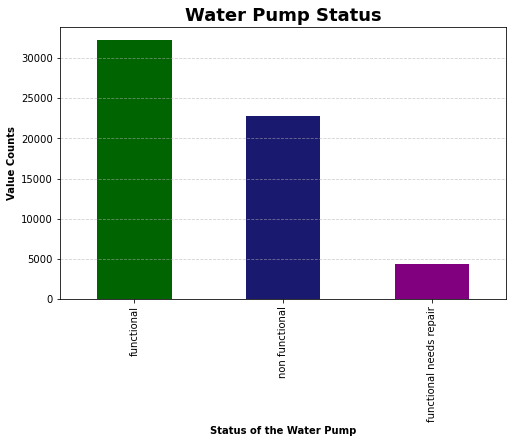

In [8]:
data['status_group'].value_counts(ascending=False).plot(kind='bar', figsize=(8,5), color=['darkgreen','midnightblue','purple'])
plt.title("Water Pump Status", fontweight='bold', fontsize=18)
plt.xlabel('Status of the Water Pump', fontweight='bold', fontsize=10) 
plt.ylabel('Value Counts', fontweight='bold', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.6)  
plt.show()


We see that there is a lot of imbalance among our classes, hence we will combine "functional needs repair" and "non functional" into one for modelling purpose. Then We will convert our target variable to 0 and 1, so now we can drop status group while modelling.

In [9]:
data['status_group'] = data['status_group'].replace(to_replace =["functional needs repair", "non functional"],value ="needs repair")
data['status_group'].value_counts()

functional      32259
needs repair    27141
Name: status_group, dtype: int64

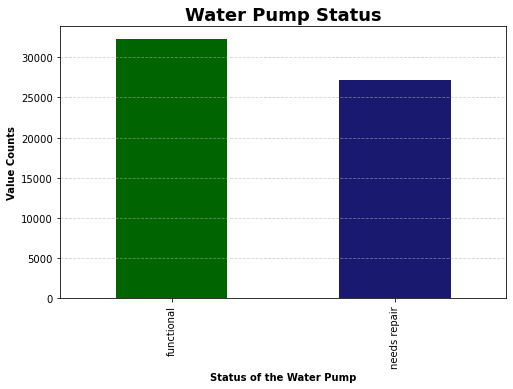

In [10]:
data['status_group'].value_counts(ascending=False).plot(kind='bar', figsize=(8,5), color=['darkgreen','midnightblue','purple'])
plt.title("Water Pump Status", fontweight='bold', fontsize=18)
plt.xlabel('Status of the Water Pump', fontweight='bold', fontsize=10) 
plt.ylabel('Value Counts', fontweight='bold', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.6)  
plt.show()

In [11]:
data['status_group'] = data['status_group'].astype('category')
data['target'] = data['status_group'].cat.codes
data['target'].value_counts()

0    32259
1    27141
Name: target, dtype: int64

In [12]:
data.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0
3,67743,needs repair,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0


In [13]:
data['status_group'].value_counts(normalize=True)

functional      0.543081
needs repair    0.456919
Name: status_group, dtype: float64

We are going to use these numbers as a baseline when comparing subgroups. For example,if a region has less than 54% functionality, we know they are below average and some features within that region are effecting the functionality of the wells.

This will help us identify important features more easily, and give us references for further data exploration.

NOTE. we can drop irrelevant columns here nime opt kuzi ignore tu (John recommend)

In [14]:
# create dummies for status group to make plotting easier
dummies_status = pd.get_dummies(data['status_group'])
data = data.join(dummies_status)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     59400 non-null  int64   
 1   status_group           59400 non-null  category
 2   amount_tsh             59400 non-null  float64 
 3   date_recorded          59400 non-null  object  
 4   funder                 55765 non-null  object  
 5   gps_height             59400 non-null  int64   
 6   installer              55745 non-null  object  
 7   longitude              59400 non-null  float64 
 8   latitude               59400 non-null  float64 
 9   wpt_name               59400 non-null  object  
 10  num_private            59400 non-null  int64   
 11  basin                  59400 non-null  object  
 12  subvillage             59029 non-null  object  
 13  region                 59400 non-null  object  
 14  region_code            59400 non-null 

### 2. EXPLORATION ON CATEGORICAL FEATURES
    2.1 Plotting functions for categorical variables
     
     we run a couple of categorical features which recommend what values/columns to maintain or drop

In [15]:
# plotting functions for categorical variables
def plot_percent(col):
    """Plot the mean functionalities of pumps compared to 'col'
    
    args:
        col (str): column name
    """
    if data[col].nunique() > 4:
        rows = 2
        cols = 1
        width = 12 if data[col].nunique() > 12 else data[col].nunique()
        height = 14
    else:
        rows = 1
        cols = 2
        width = 12
        height = 3
    fig, ax = plt.subplots(rows, cols, figsize=(width, height))
        
    for idx, status in enumerate(data['status_group'].unique().tolist()):
        data.groupby(col).mean()[status].sort_values().plot.bar(ax=ax[idx])
        ax[idx].axhline(y=data[status].mean(), color='r', linestyle='-')
        ax[idx].set_title(f"{status.title()} pumps by {col.title()}", fontsize=14)
        ax[idx].set_ylabel('Percent')
        ax[idx].set_xlabel('')
        ax[idx].set_ylim(0,data.groupby(col).mean()[status].max()*1.2);
    fig.tight_layout()

In [16]:
# FUNDER
print(f"Unique Values: {data['funder'].nunique()}")
print(f"Missing Values: {data['funder'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['funder'] == '0').sum()} (wells with '0' as the value)")
data['funder'].value_counts().head(20)

#INSTALLER
print(f"Unique Values: {data['installer'].nunique()}")
print(f"Missing Values: {data['installer'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['installer'] == '0').sum()} (wells with '0' as the value)")
data['installer'].value_counts().head(20)

Unique Values: 1897
Missing Values: 3635/59400
Possible Missing Values: 777 (wells with '0' as the value)
Unique Values: 2145
Missing Values: 3655/59400
Possible Missing Values: 777 (wells with '0' as the value)


DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
LGA                     408
World vision            408
WEDECO                  397
TASAF                   396
District council        392
Name: installer, dtype: int64

We see that DWE (District Water Engineering) and Govt are the major installers which is similar to our funders.

In [17]:
#WE TRY BASIN CATEGORY

print(f"Basins: {data['basin'].nunique()}")
print(f"Region: {data['region'].nunique()}")
print(f"Districts: {data['district_code'].nunique()}")
print(f"LGAs: {data['lga'].nunique()}")
print(f"Wards: {data['ward'].nunique()}")
print(f"Subvillages: {data['subvillage'].nunique()}")

Basins: 9
Region: 21
Districts: 20
LGAs: 125
Wards: 2092
Subvillages: 19287


In [18]:
data.groupby(['basin', 'region', 'region_code', 'district_code', 'lga', 'ward', 'subvillage'])[
    ['functional', 'needs repair']].agg(['mean','sum']).head()

functional  \
                                                                            mean   
basin    region region_code district_code lga     ward     subvillage              
Internal Arusha 2           1             Monduli Engaruka Hyhh              0.0   
                                                           Madukani          0.0   
                                                           Mkaoo             0.0   
                                                           Mula              0.0   
                                                           Mwembeni          0.0   

                                                                           \
                                                                      sum   
basin    region region_code district_code lga     ward     subvillage       
Internal Arusha 2           1             Monduli Engaruka Hyhh         0   
                                                           Madukani     0   
                                                           Mkaoo        0   
                                                           Mula         0   
                                                           Mwembeni     0   

                                                                      needs repair  \
                                                                              mean   
basin    region region_code district_code lga     ward     subvillage                
Internal Arusha 2           1             Monduli Engaruka Hyhh                1.0   
                                                           Madukani            1.0   
                                                           Mkaoo               1.0   
                                                           Mula                1.0   
                                                           Mwembeni            1.0   

                                                                           
                                                                      sum  
basin    region region_code district_code lga     ward     subvillage      
Internal Arusha 2           1             Monduli Engaruka Hyhh         1  
                                                           Madukani     1  
                                                           Mkaoo        3  
                                                           Mula         1  
                                                           Mwembeni     1

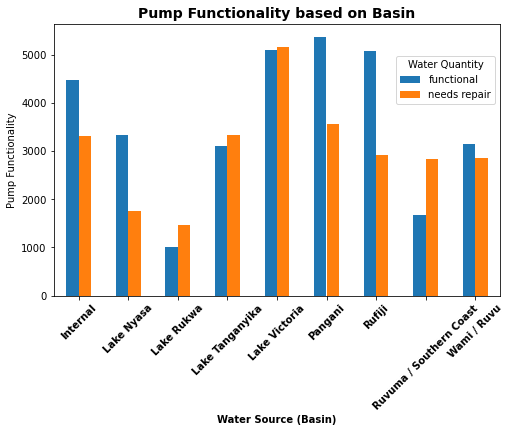

In [19]:
sub_df = data.groupby('basin')['status_group'].value_counts(ascending=True).unstack()
sub_df.plot(kind='bar', figsize=(8,5))
plt.xlabel("Water Source (Basin)", fontweight='bold')
plt.xticks(rotation=45,fontweight='bold')
plt.ylabel("Pump Functionality")
plt.title('Pump Functionality based on Basin', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 0.9), title='Water Quantity');

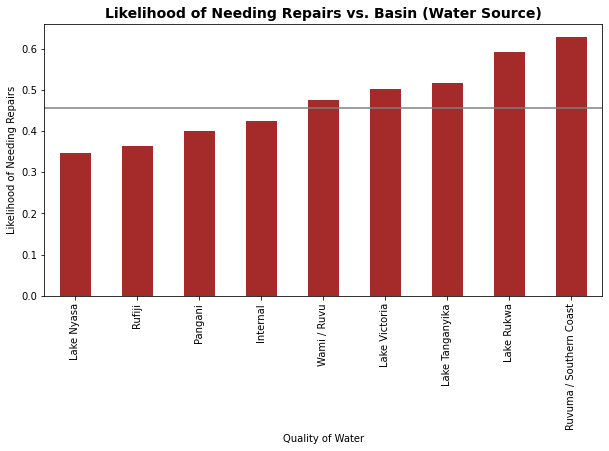

In [20]:
source_df = data.groupby('basin')['target'].mean()
source_df.sort_values().plot(kind='bar', color=['brown'], figsize=(10,5))
plt.xlabel("Quality of Water")
plt.xticks(rotation=90)
plt.axhline(y=data['target'].mean(),color='gray') 
plt.ylabel("Likelihood of Needing Repairs")
plt.title('Likelihood of Needing Repairs vs. Basin (Water Source)', fontsize=14, fontweight='bold');

Lake Nyasa, Pangani, Rufiji seem to have more than 60% of their pumps functioning with a less likelihood of needing repaires.

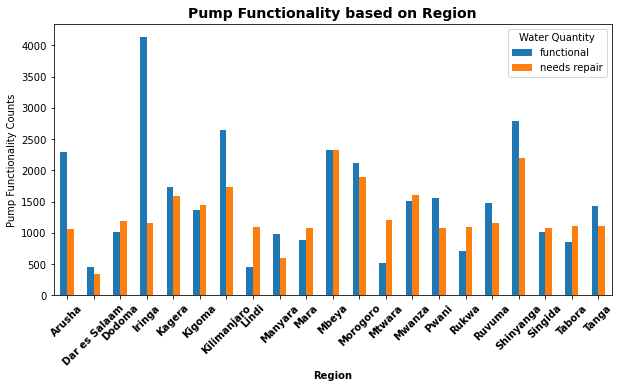

In [21]:
#REGION
sub_df = data.groupby('region')['status_group'].value_counts(ascending=True).unstack()
sub_df.plot(kind='bar', figsize=(10,5))
plt.xlabel("Region", fontweight='bold')
plt.xticks(rotation=45,fontweight='bold')
plt.ylabel("Pump Functionality Counts")
plt.title('Pump Functionality based on Region', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 1.0), title='Water Quantity');


Unique Values: 2
Missing Values: 3334/59400
Possible Missing Values: 0 (wells with '0' as the value)


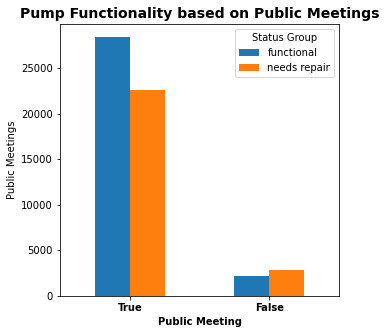

In [22]:
# PUBLIC MEETING
print(f"Unique Values: {data['public_meeting'].nunique()}")
print(f"Missing Values: {data['public_meeting'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['public_meeting'] == '0').sum()} (wells with '0' as the value)")
data['public_meeting'].value_counts().head(20)

sub_df = data.groupby('public_meeting')['status_group'].value_counts(ascending=False).unstack()
sub_df.sort_values(by='public_meeting',ascending=False).plot(kind='bar', figsize=(5,5))
plt.xlabel("Public Meeting", fontweight='bold')
plt.xticks(rotation=0,fontweight='bold')
plt.ylabel("Public Meetings")
plt.title('Pump Functionality based on Public Meetings', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 1.0), title='Status Group');

(HHAHAHhahaha interesting to see meetings do have an impact )    now we print  to see wat kind of managment work in this meetings

In [23]:
print(f"Unique Values: {data['management'].nunique()}")
print(f"Missing Values: {data['management'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['management'] == '0').sum()} (wells with '0' as the value)")
data['management'].value_counts().head(20)



Unique Values: 12
Missing Values: 0/59400
Possible Missing Values: 0 (wells with '0' as the value)


vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [24]:
print(f"Unique Values: {data['management'].nunique()}")
print(f"Missing Values: {data['management'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['management'] == '0').sum()} (wells with '0' as the value)")
data['management'].value_counts().head(20)

Unique Values: 12
Missing Values: 0/59400
Possible Missing Values: 0 (wells with '0' as the value)


vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [25]:
data.groupby(['management_group', 'management'])[['functional', 'needs repair']].mean()

functional  needs repair
management_group management                                
commercial       company             0.389781      0.610219
                 private operator    0.748858      0.251142
                 trust               0.589744      0.410256
                 water authority     0.493363      0.506637
other            other               0.598341      0.401659
                 other - school      0.232323      0.767677
parastatal       parastatal          0.576923      0.423077
unknown          unknown             0.399287      0.600713
user-group       vwc                 0.504234      0.495766
                 water board         0.739857      0.260143
                 wua                 0.690730      0.309270
                 wug                 0.599540      0.400460

In [26]:
# PAYMENT
print(f"Unique Values: {data['payment'].nunique()}")
print(f"Missing Values: {data['payment'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['payment'] == '0').sum()} (wells with '0' as the value)")
data['payment'].value_counts().head(20)

print(f"Unique Values: {data['payment_type'].nunique()}")
print(f"Missing Values: {data['payment_type'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['payment_type'] == '0').sum()} (wells with '0' as the value)")
data['payment_type'].value_counts().head(20)

Unique Values: 7
Missing Values: 0/59400
Possible Missing Values: 0 (wells with '0' as the value)
Unique Values: 7
Missing Values: 0/59400
Possible Missing Values: 0 (wells with '0' as the value)


never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

payment_type - similar to payment.Hence we will be dropping payment_type

### 2.1 . EXPLORATION ON NON-CATEGORICAL FEATURES

In [27]:
# GPS-HEIGHT
print(f"Unique Values: {data['gps_height'].nunique()}")
print(f"Missing Values: {data['gps_height'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['gps_height'] == '0').sum()} (wells with '0' as the value)")
data['gps_height'].value_counts().head(20)

Unique Values: 2428
Missing Values: 0/59400
Possible Missing Values: 0 (wells with '0' as the value)


 0       20438
-15         60
-16         55
-13         55
-20         52
 1290       52
-14         51
 303        51
-18         49
-19         47
 1269       46
 1295       46
 1304       45
-23         45
 280        44
 1538       44
 1286       44
-8          44
-17         44
 1332       43
Name: gps_height, dtype: int64

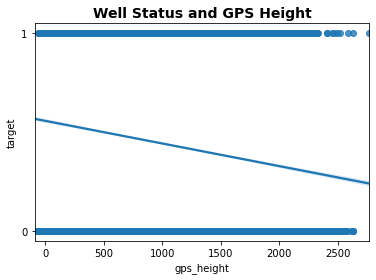

In [28]:
fig, ax = plt.subplots(1)
sns.regplot(x='gps_height', y='target', data=data[(data['gps_height'] != 0)], ax=ax)
ax.set_yticks([0, 1])
plt.title('Well Status and GPS Height', fontsize=14, fontweight='bold');

definitely a strong relationship (hapa come with words)

In [29]:
#AMOUNT-TSH
print(f"Unique Values: {data['amount_tsh'].nunique()}")
print(f"Missing Values: {data['amount_tsh'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['amount_tsh'] == '0').sum()} (wells with '0' as the value)")
data['amount_tsh'].value_counts().head(20)

Unique Values: 98
Missing Values: 0/59400
Possible Missing Values: 0 (wells with '0' as the value)


0.0       41639
500.0      3102
50.0       2472
1000.0     1488
20.0       1463
200.0      1220
100.0       816
10.0        806
30.0        743
2000.0      704
250.0       569
300.0       557
5000.0      450
5.0         376
25.0        356
3000.0      334
1200.0      267
1500.0      197
6.0         190
600.0       176
Name: amount_tsh, dtype: int64

Since 90% of the data is 0's, hence we will be dropping this when modelling.


In [30]:
#CONSTRUCTION YEAR
print(f"Unique Values: {data['construction_year'].nunique()}")
print(f"Missing Values: {data['construction_year'].isna().sum()}/{data.shape[0]}")
print(f"Possible Missing Values: {(data['construction_year'] == '0').sum()} (wells with '0' as the value)")
data['construction_year'].value_counts().head(20)

Unique Values: 55
Missing Values: 0/59400
Possible Missing Values: 0 (wells with '0' as the value)


0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
Name: construction_year, dtype: int64

We create a new column to better understand the con_ year better

In [31]:
from datetime import datetime
data['age_of_well']=datetime.now().year - data['construction_year']

data['age_of_well'].value_counts()

2024    20709
14       2645
16       2613
15       2533
24       2091
17       1587
18       1471
21       1286
13       1256
20       1123
12       1084
22       1075
46       1037
29       1014
19       1011
25        979
26        966
34        954
39        945
44        811
28        811
40        779
42        744
30        738
52        708
50        676
27        644
32        640
31        608
23        540
36        521
41        488
49        437
38        434
48        414
54        411
33        324
35        316
37        302
43        238
47        202
45        192
51        184
11        176
53        145
64        102
57         88
61         85
56         77
55         59
60         40
62         30
63         21
59         19
58         17
Name: age_of_well, dtype: int64

In [32]:
data = data[(data['construction_year'] > 0) & (data['population'] > 0) & (data['gps_height'] > 0)]
data

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target,functional,needs repair,age_of_well
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,1,0,25
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,1,0,14
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0,1,0,15
3,67743,needs repair,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1,0,1,38
10,49056,functional,0.0,2011-02-20,Private,62,Private,39.209518,-7.034139,Mzee Hokororo,...,enough,machine dbh,borehole,groundwater,other,other,0,1,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59391,44885,needs repair,0.0,2013-08-03,Government Of Tanzania,540,Government,38.044070,-4.272218,Kwa,...,enough,river,river/lake,surface,communal standpipe,communal standpipe,1,0,1,57
59394,11164,needs repair,500.0,2011-03-09,World Bank,351,ML appro,37.634053,-6.124830,Chimeredya,...,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,1,0,1,17
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,1,0,25
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,...,enough,river,river/lake,surface,communal standpipe,communal standpipe,0,1,0,28


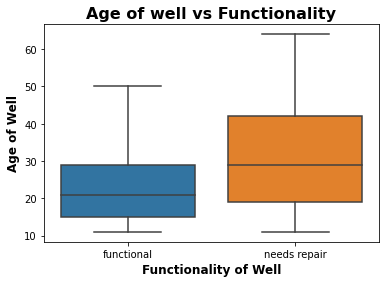

In [33]:
sns.boxplot(x='status_group',y='age_of_well', data=data, showfliers=False)
plt.xlabel('Functionality of Well', fontsize=12, fontweight='bold');
plt.ylabel('Age of Well', fontsize=12, fontweight='bold');
plt.title('Age of well vs Functionality', fontsize=16, fontweight='bold');

0 is Funtional
1 is Non Funtional or Needs repair

So we see, that newer the well is, more chances of it being functional

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35319 entries, 0 to 59399
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     35319 non-null  int64   
 1   status_group           35319 non-null  category
 2   amount_tsh             35319 non-null  float64 
 3   date_recorded          35319 non-null  object  
 4   funder                 33982 non-null  object  
 5   gps_height             35319 non-null  int64   
 6   installer              33977 non-null  object  
 7   longitude              35319 non-null  float64 
 8   latitude               35319 non-null  float64 
 9   wpt_name               35319 non-null  object  
 10  num_private            35319 non-null  int64   
 11  basin                  35319 non-null  object  
 12  subvillage             35309 non-null  object  
 13  region                 35319 non-null  object  
 14  region_code            35319 non-null 

In [35]:
data = data.drop_duplicates()

In [36]:
to_drop = ['wpt_name','id','date_recorded','recorded_by','region_code',
           'lga','scheme_name','funder','subvillage','latitude',
           'longitude','extraction_type_class','extraction_type',
           'payment_type','quantity_group','source_type','waterpoint_type_group',
           'district_code','amount_tsh','num_private','construction_year',
           'status_group','population','functional','needs repair','management'
          ]

In [37]:
data = data.drop(to_drop, axis=1)
data = data.dropna()
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29361 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gps_height             29361 non-null  int64 
 1   installer              29361 non-null  object
 2   basin                  29361 non-null  object
 3   region                 29361 non-null  object
 4   ward                   29361 non-null  object
 5   public_meeting         29361 non-null  object
 6   scheme_management      29361 non-null  object
 7   permit                 29361 non-null  object
 8   extraction_type_group  29361 non-null  object
 9   management_group       29361 non-null  object
 10  payment                29361 non-null  object
 11  water_quality          29361 non-null  object
 12  quality_group          29361 non-null  object
 13  quantity               29361 non-null  object
 14  source                 29361 non-null  object
 15  source_class       

# MODELING

CREATE Y & X AXIS

In [38]:
X = data.drop(['target'], axis=1)
y = data['target']

X.head()
y.head()

0     0
2     0
3     1
10    0
11    0
Name: target, dtype: int8

In [39]:
numerical_cols = list(X.select_dtypes(include=np.number).columns)
categorical_cols = list(X.select_dtypes(exclude=np.number).columns)

Models
LinearSVC
XGBoost
Random Forest

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import xgboost as xgboost

def fit_predict(model, X_train, X_test, y_train, y_test):
    '''fit pipeline using given model, and return predictions'''
    
    param_grid = model['params']
    model = model['model']
        
    
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                                 ])

    search = GridSearchCV(estimator=my_pipeline,
             param_grid=param_grid, n_jobs=-1, verbose=2, cv=10)
    
    search.fit(X_train, y_train)
    
    best_estimator = search.best_estimator_._final_estimator
    
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    # Preprocessing of validation data, get predictions
    test_preds = search.predict(X_test)
    train_preds = search.predict(X_train)
    
    return test_preds, train_preds, search

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(y_true, y_preds):
    # Print confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_preds)
    # Create the basic matrix
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)
    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Add appropriate axis scales
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks, class_names)
    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')
    # Add a legend
    plt.colorbar();
    plt.show();

def metrics(model_name, y_train, y_test, y_train_pred, y_test_pred):
    '''Print out the evaluation metrics for a given models predictions'''
    print(f'Model: {model_name}', )
    print('-'*60)
    plot_confusion_matrix(y_test,y_test_pred)
    print(f'test accuracy: {accuracy_score(y_test, y_test_pred)}')
    print(f'train accuracy: {accuracy_score(y_train, y_train_pred)}')
    print('-'*60)
    print('\ntest report:\n' + classification_report(y_test, y_test_pred))
    print('~'*60)
    print('\ntrain report:\n' + classification_report(y_train, y_train_pred))    
    print('-'*60)

In [43]:
def roc(X_test, y_test, pred_y, model):
    name=str(model.best_estimator_.named_steps["model"])[:str(model.best_estimator_.named_steps["model"]).index('(')]
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label = model)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {name}')
    plt.show()

In [44]:
smallest_num = data['target'].value_counts().sort_values().values[0]
target_0 = data[data['target'] == 0].sample(smallest_num)
target_1 = data[data['target'] == 1].sample(smallest_num)
sampled_df = pd.concat([target_0, target_1])

In [45]:
sampled_df['target'].value_counts()

1    12664
0    12664
Name: target, dtype: int64

In [46]:
X_sampled_df = sampled_df.drop('target', axis=1)
y_sampled_df = sampled_df['target']

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sampled_df, y_sampled_df, test_size=.3, random_state=42)

X_sampled_df.head()

,gps_height,installer,basin,region,ward,public_meeting,scheme_management,permit,extraction_type_group,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type,age_of_well
1553,1522,DWE,Pangani,Arusha,Murieti,True,VWC,True,gravity,user-group,never pay,soft,good,insufficient,spring,groundwater,communal standpipe,22
32778,1012,WVC,Lake Nyasa,Ruvuma,Msindo,True,VWC,True,gravity,user-group,pay annually,soft,good,enough,river,surface,communal standpipe,12
38775,1538,Dmdd,Internal,Arusha,Qurus,True,VWC,True,gravity,user-group,pay per bucket,soft,good,enough,river,surface,communal standpipe,22
41178,1089,Ha,Wami / Ruvu,Morogoro,Lumuma,True,VWC,True,swn 80,user-group,pay when scheme fails,soft,good,insufficient,shallow well,groundwater,hand pump,14
18381,1364,WVT,Lake Victoria,Shinyanga,Mhunze,True,WUG,False,india mark ii,user-group,never pay,soft,good,insufficient,machine dbh,groundwater,hand pump,15


In [48]:
X_sampled_df.shape[0]

25328

In [49]:
lsvc_param = {
    'model__C': [1, 10], #the higher the C, the more penalty SVM was given when it misclassified
    'model__max_iter': [10000], # maximum number of iterations to be run.
    'model__dual':[False],  # dual=False when n_samples > n_features.
    'model__penalty': ['l1','l2'],# Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in 
                                  # SVC. The ‘l1’ leads to coef_ vectors that are sparse.
}

In [50]:
from sklearn.svm import LinearSVC

lsvc = { 'model': LinearSVC(random_state=42), 'params': lsvc_param }

lsvc_test_preds, lsvc_train_preds,lsvc_pipeline = fit_predict(lsvc, X_train, X_test, y_train, y_test)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.4min finished


Best parameter (CV score=0.785):
{'model__C': 1, 'model__dual': False, 'model__max_iter': 10000, 'model__penalty': 'l1'}


Model: LinearSVC
------------------------------------------------------------


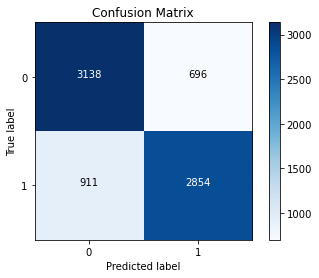

test accuracy: 0.7885248058955125
train accuracy: 0.8325906706526031
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3834
           1       0.80      0.76      0.78      3765

    accuracy                           0.79      7599
   macro avg       0.79      0.79      0.79      7599
weighted avg       0.79      0.79      0.79      7599

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      8830
           1       0.85      0.81      0.83      8899

    accuracy                           0.83     17729
   macro avg       0.83      0.83      0.83     17729
weighted avg       0.83      0.83      0.83     17729

------------------------------------------------------------


In [51]:
metrics('LinearSVC', y_train, y_test, lsvc_train_preds, lsvc_test_preds)

In [52]:
# Importing the libraries
import pandas as pd
import numpy as np

from scipy import stats
import math

#Visual/Graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import warnings
import warnings
warnings.filterwarnings("ignore")

import pandas.util.testing as tm

In [53]:
def top_feat(model_pipe):
    '''This function is used to find the best features of our models
    
    Args:
        model_pipe (GridSearchCV): model_pipe is a pipeline
    
    Returns:
        the top features of the model
    '''
    
    onehot_columns = list(model_pipe.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_cols))
    numeric_features_list = list(numerical_cols)
    numeric_features_list.extend(onehot_columns)
    return eli5.explain_weights(model_pipe.best_estimator_.named_steps['model'], top=20, feature_names=numeric_features_list)

In [54]:
xgb_param = {
    'model__eta': [.3, .2, .1, .05, .01, .005], #Learning rate
    'model__max_depth': [10], #The maximum depth of a tree.Used to control over-fitting
    'model__min_child_weight': [6], # minimum sum of weights of all observations required in a child
    'model__subsample': [0.8]      # Subsample ratio of the training instances.
}

In [55]:
from xgboost import XGBClassifier

xgb = { 'model': XGBClassifier(random_state=42), 'params': xgb_param }

xgb_test_preds, xgb_train_preds, xgb_pipeline = fit_predict(xgb, X_train, X_test, y_train, y_test)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


Best parameter (CV score=0.798):
{'model__eta': 0.2, 'model__max_depth': 10, 'model__min_child_weight': 6, 'model__subsample': 0.8}


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

XGBoost_accuracy = accuracy_score(y_test, xgb_test_preds)
XGBoost_precision = precision_score(y_test, xgb_test_preds)
# ... calculate other metrics

print(f"XGBoost Accuracy: {XGBoost_accuracy}")
print(f"XGBoost Precision: {XGBoost_precision}")
# ... print other metric values


XGBoost Accuracy: 0.804842742466114
XGBoost Precision: 0.8241477272727272


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate and print various metrics using the same data you provided to `metrics`
XGBoost_accuracy = accuracy_score(y_test, xgb_test_preds)
XGBoost_precision = precision_score(y_test, xgb_test_preds)
XGBoost_recall = recall_score(y_test, xgb_test_preds)
XGBoost_f1 = f1_score(y_test, xgb_test_preds)

print(f"XGBoost Accuracy: {XGBoost_accuracy}")
print(f"XGBoost Precision: {XGBoost_precision}")
print(f"XGBoost Recall: {XGBoost_recall}")
print(f"XGBoost F1-score: {XGBoost_f1}")


XGBoost Accuracy: 0.804842742466114
XGBoost Precision: 0.8241477272727272
XGBoost Recall: 0.7705179282868526
XGBoost F1-score: 0.7964310226492793


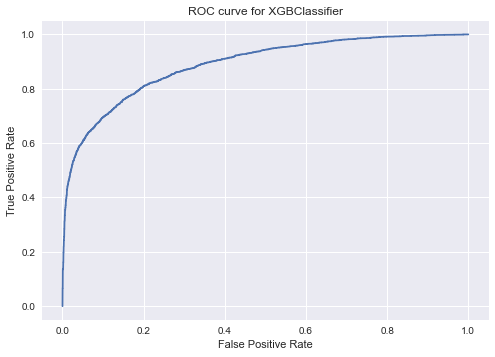

In [60]:
roc(X_test,y_test,xgb_test_preds,xgb_pipeline)

errors im getting r for visualizing (nimelemewa)

In [64]:
top_feat(xgb_pipeline)

NameError: name 'eli5' is not defined

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

forest_params = {'model__n_estimators' : [500,1000],  # number of decision trees to be created
                 'model__criterion' : ['gini','entropy'], # function that is to be used for splitting
                 'model__max_depth': [10],          # maximum depth of the trees
                 'model__min_samples_split' : [10], # minimum number of samples required in a leaf node before a split is attempted
                 'model__min_samples_leaf' : [5]} # minimum number of samples required to be at a leaf node. 
                                            # Smaller leaf size makes the model more prone to capturing noise in train data.
rfc = { 'model': RandomForestClassifier(random_state=42), 'params': forest_params }

rfc_test_preds, rfc_train_preds,rfc_pipeline = fit_predict(rfc, X_train, X_test, y_train, y_test)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished


Best parameter (CV score=0.746):
{'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 500}


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rfc_test_preds, rfc_train_preds, rfc_pipeline = fit_predict(rfc, X_train, X_test, y_train, y_test)

random_forest_accuracy = accuracy_score(y_test, rfc_test_preds)
random_forest_precision = precision_score(y_test, rfc_test_preds)
# ... calculate other metrics

print(f"Random Forest Accuracy: {random_forest_accuracy}")
print(f"Random Forest Precision: {random_forest_precision}")
# ... print other metric values


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished


Best parameter (CV score=0.746):
{'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 500}
Random Forest Accuracy: 0.7482563495196737
Random Forest Precision: 0.7563676633444075


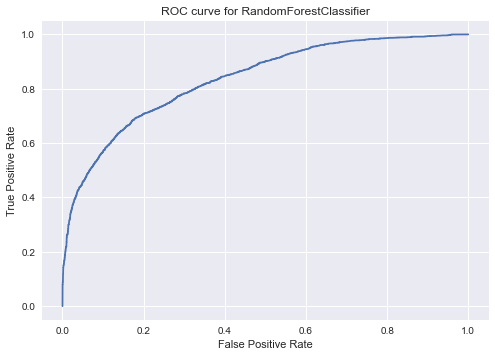

In [68]:
roc(X_test,y_test,rfc_test_preds,rfc_pipeline)

finaly i wanted to print all the models with there xtest and xtrain(pia hi nimelemewa)